## P10
Małgorzata Kurcjusz-Gzowska 


- https://arxiv.org/abs/0711.0189
- https://ieeexplore.ieee.org/document/868688/authors#authors
- https://proceedings.neurips.cc/paper_files/paper/2001/file/801272ee79cfde7fa5960571fee36b9b-Paper.pdf

In [22]:
import os
import time
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [23]:
COMP_DIR = "./competition"    
OUT_DIR = "./results"          
os.makedirs(OUT_DIR, exist_ok=True)

RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [24]:
STUDENT_NAME = "Malgorzata Kurcjusz-Gzowska"
GITHUB_LINK = "https://github.com/MKurcjusz/SNARS/tree/main/P10_SNARS"  

In [25]:
def load_adjacency(path: str) -> np.ndarray:
    """
    Wczytaj macierz sąsiedztwa z pliku CSV.
    Zakładamy graf nieskierowany bez pętli.
    """
    A = pd.read_csv(path, header=None).to_numpy(dtype=float)
    # wyzeruj diagonalę
    np.fill_diagonal(A, 0.0)
    # wymuś symetrię
    A = np.triu(A) + np.triu(A, 1).T
    return A


def parse_target_k(filename: str):
    """
    Jeśli w nazwie pliku jest fragment typu K=7,
    zwróć tę liczbę. W przeciwnym razie None.
    """
    m = re.search(r"K=(\d+)", filename)
    return int(m.group(1)) if m else None


def write_solution_file(out_path: str, labels_zero_based: np.ndarray):
    """
    Format wymagany w konkursie:
      1, numer_klastra_wierzcholka_1
      2, numer_klastra_wierzcholka_2
      ...
    Wierzchołki numerowane od 1 do n, etykiety klastrów od 1, kolejne liczby całkowite.
    """
    labels_one_based = labels_zero_based + 1
    with open(out_path, "w", encoding="utf-8") as f:
        for v0, c in enumerate(labels_one_based):
            f.write(f"{v0 + 1}, {int(c)}\n")

In [26]:
def normalized_laplacian(A: np.ndarray) -> np.ndarray:
    """
    Zwraca znormalizowaną macierz Laplasjana:
    L = I - D^{-1/2} A D^{-1/2}
    """
    n = A.shape[0]
    deg = A.sum(axis=1)
    with np.errstate(divide="ignore"):
        d_inv_sqrt = 1.0 / np.sqrt(deg)
    d_inv_sqrt[~np.isfinite(d_inv_sqrt)] = 0.0
    D_inv_sqrt = np.diag(d_inv_sqrt)
    I = np.eye(n)
    L = I - D_inv_sqrt @ A @ D_inv_sqrt
    return L


def kmeans(X: np.ndarray, K: int, n_init: int = 10, max_iter: int = 100) -> np.ndarray:
    """
    Prosta implementacja k-means.
    Zwraca etykiety w {0, ..., K-1}.
    """
    n, d = X.shape
    best_labels = None
    best_inertia = None

    for _ in range(n_init):
        # losowy wybór początkowych centroidów
        indices = np.random.choice(n, size=K, replace=False)
        centroids = X[indices].copy()

        for it in range(max_iter):
            # macierz odległości kwadratowych (n x K)
            diff = X[:, None, :] - centroids[None, :, :]
            dist2 = np.sum(diff * diff, axis=2)
            labels = np.argmin(dist2, axis=1)

            # aktualizacja centroidów
            new_centroids = np.zeros_like(centroids)
            for k in range(K):
                members = X[labels == k]
                if len(members) == 0:
                    # pusty klaster dostaje losowy punkt
                    new_centroids[k] = X[np.random.randint(0, n)]
                else:
                    new_centroids[k] = members.mean(axis=0)

            if np.allclose(new_centroids, centroids):
                centroids = new_centroids
                break
            centroids = new_centroids

        diff = X - centroids[labels]
        inertia = np.sum(diff * diff)
        if best_inertia is None or inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels.copy()

    return best_labels


In [27]:
def modularity(A: np.ndarray, labels: np.ndarray) -> float:
    """
    Modułowość Newmana Girvana dla grafu nieskierowanego.
    """
    m2 = A.sum()
    if m2 == 0:
        return 0.0
    m = m2 / 2.0
    k = A.sum(axis=1)

    Q = 0.0
    for c in np.unique(labels):
        nodes = np.where(labels == c)[0]
        if len(nodes) == 0:
            continue
        A_rr = A[np.ix_(nodes, nodes)].sum()
        k_r = k[nodes].sum()
        Q += A_rr - (k_r ** 2) / (2.0 * m)
    Q /= (2.0 * m)
    return float(Q)


def refine_labels_modularity(A: np.ndarray,
                             labels: np.ndarray,
                             max_iter: int = 10):
    """
    Lokalna poprawa: dla każdego wierzchołka próbujemy przeniesienia do innych istniejących społeczności jeśli zwiększa to modułowość.
    """
    labels = labels.copy()
    base_Q = modularity(A, labels)
    n = len(labels)

    for _ in range(max_iter):
        improved = False
        nodes = list(range(n))
        random.shuffle(nodes)

        for i in nodes:
            current_comm = labels[i]
            best_comm = current_comm
            best_Q = base_Q

            communities = list(np.unique(labels))
            for c in communities:
                if c == current_comm:
                    continue
                labels[i] = c
                Q_new = modularity(A, labels)
                if Q_new > best_Q + 1e-9:
                    best_Q = Q_new
                    best_comm = c

            labels[i] = best_comm
            if best_comm != current_comm:
                base_Q = best_Q
                improved = True

        if not improved:
            break

    return labels, base_Q


def choose_k_from_spectrum(eigvals: np.ndarray, max_k: int = 15) -> int:
    """
    Wybór liczby klastrów na podstawie przerwy w widmie znormalizowanego Laplasjana.
    """
    # bierzemy pierwsze max_k + 1 wartości własne
    m = min(len(eigvals) - 1, max_k)
    if m <= 1:
        return 2
    gaps = eigvals[1:m + 1] - eigvals[:m]
    # ignorujemy pierwszą przerwę, szukamy maksimum dalej
    best_idx = np.argmax(gaps[1:]) + 1  # indeks w gaps
    K_est = best_idx + 1                # liczba klastrów
    return max(2, K_est)


def spectral_community_detection(A: np.ndarray,
                                 known_k: int | None = None,
                                 max_k: int = 15,
                                 refine: bool = True):
    """
    Główny algorytm:
      1) Laplasjan znormalizowany
      2) wartości i wektory własne
      3) k-means w przestrzeni wybranych wektorów własnych
      4) opcjonalna poprawa modułowości
    """
    n = A.shape[0]
    L = normalized_laplacian(A)
    eigvals, eigvecs = np.linalg.eigh(L)
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    if known_k is None:
        K = min(max_k, n)
        K = choose_k_from_spectrum(eigvals, max_k=max_k)
    else:
        K = int(known_k)

    # bierzemy pierwsze K wektorów własnych jako cechy
    X = eigvecs[:, :K]
    labels0 = kmeans(X, K)

    if refine:
        labels, Q = refine_labels_modularity(A, labels0)
    else:
        labels = labels0
        Q = modularity(A, labels0)

    # przemapowanie etykiet na 0..K'-1
    unique = sorted(np.unique(labels))
    mapping = {c: i for i, c in enumerate(unique)}
    labels = np.array([mapping[c] for c in labels], dtype=int)
    K_effective = len(unique)

    return labels, Q, K_effective

In [28]:
def plot_partition(A: np.ndarray,
                   labels: np.ndarray,
                   title: str = ""):
    """
    Rysuje graf i koloruje wierzchołki według społeczności.
    """
    n = A.shape[0]
    G = nx.from_numpy_array(A)
    pos = nx.spring_layout(G, seed=RANDOM_SEED)
    k = len(np.unique(labels))

    cmap = plt.cm.get_cmap("tab20", k)
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_edges(G, pos, edge_color="lightgray", width=0.8, alpha=0.8)
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=80,
        node_color=labels,
        cmap=cmap,
        linewidths=0.3,
        edgecolors="white",
    )
    plt.title(f"{title}  K={k}")
    plt.axis("off")
    plt.show()



=== Przetwarzam D1-K=2.csv ===
Oczekiwana liczba społeczności K = 2
n = 34, m = 78, K_efektywne = 2
Modułowość Q = 0.3718
Czas obliczeń: 0.0150 s
Zapisano rozwiązanie do: ./results/D1-K=2.csv


/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_26040/498625367.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", k)


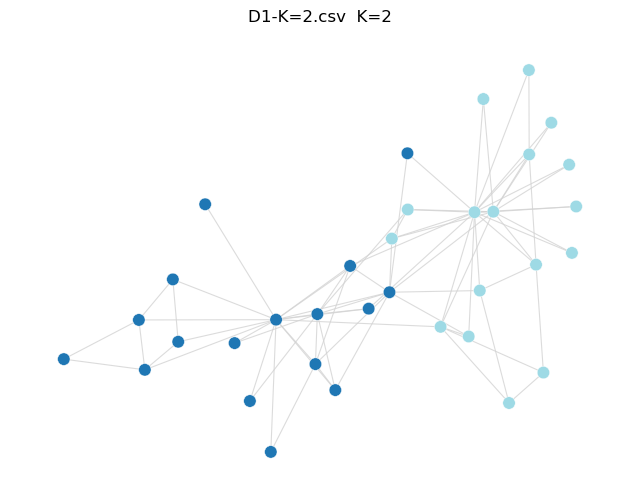


=== Przetwarzam D1-UNC.csv ===
Brak znanego K w nazwie pliku, liczba społeczności będzie dobrana automatycznie
n = 125, m = 334, K_efektywne = 15
Modułowość Q = 0.7053
Czas obliczeń: 0.6244 s
Zapisano rozwiązanie do: ./results/D1-UNC.csv


/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_26040/498625367.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", k)


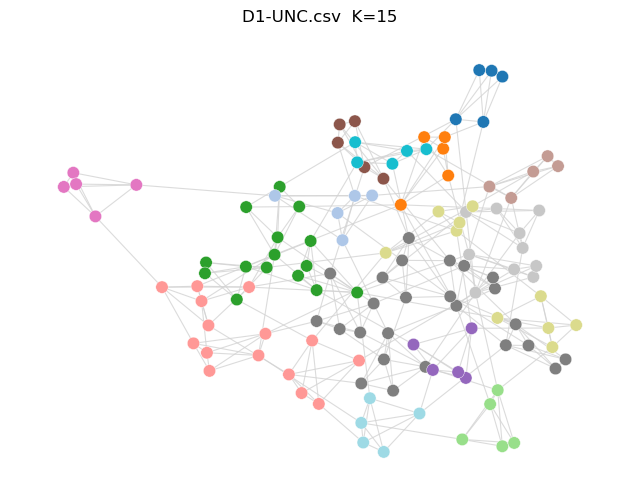


=== Przetwarzam D2-K=7.csv ===
Oczekiwana liczba społeczności K = 7
n = 62, m = 159, K_efektywne = 6
Modułowość Q = 0.5007
Czas obliczeń: 0.0940 s
Zapisano rozwiązanie do: ./results/D2-K=7.csv


/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_26040/498625367.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", k)


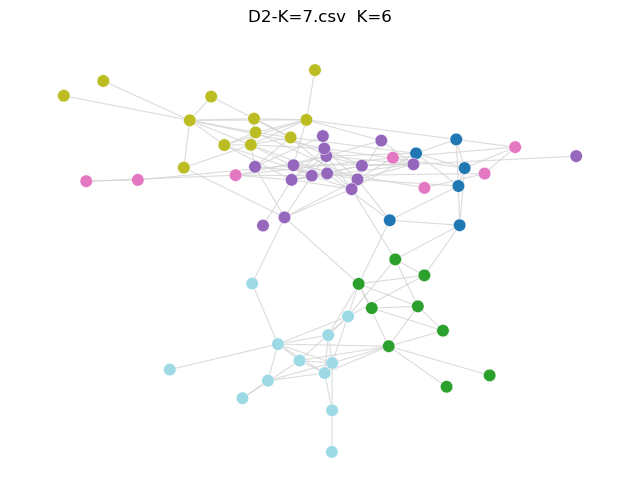


=== Przetwarzam D2-UNC.csv ===
Brak znanego K w nazwie pliku, liczba społeczności będzie dobrana automatycznie
n = 150, m = 940, K_efektywne = 15
Modułowość Q = 0.6512
Czas obliczeń: 0.3851 s
Zapisano rozwiązanie do: ./results/D2-UNC.csv


/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_26040/498625367.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", k)


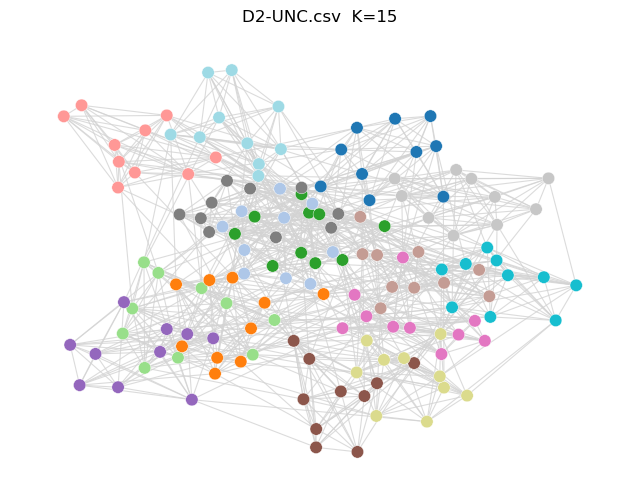


=== Przetwarzam D3-K=12.csv ===
Oczekiwana liczba społeczności K = 12
n = 115, m = 613, K_efektywne = 12
Modułowość Q = 0.6010
Czas obliczeń: 0.3743 s
Zapisano rozwiązanie do: ./results/D3-K=12.csv


/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_26040/498625367.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", k)


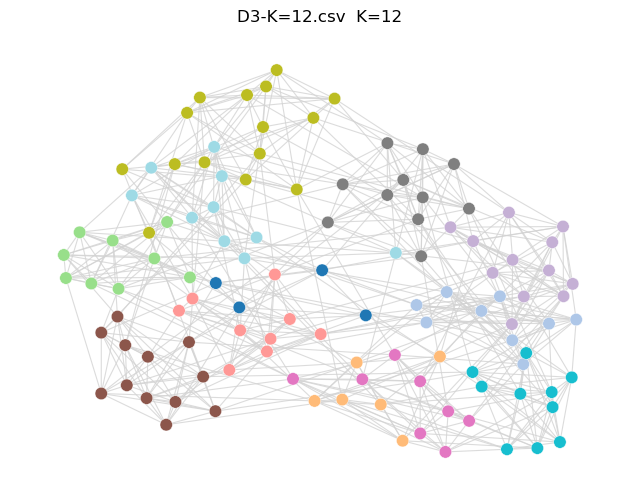


=== Przetwarzam D3-UNC.csv ===
Brak znanego K w nazwie pliku, liczba społeczności będzie dobrana automatycznie
n = 81, m = 487, K_efektywne = 9
Modułowość Q = 0.5519
Czas obliczeń: 0.0745 s
Zapisano rozwiązanie do: ./results/D3-UNC.csv


/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_26040/498625367.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", k)


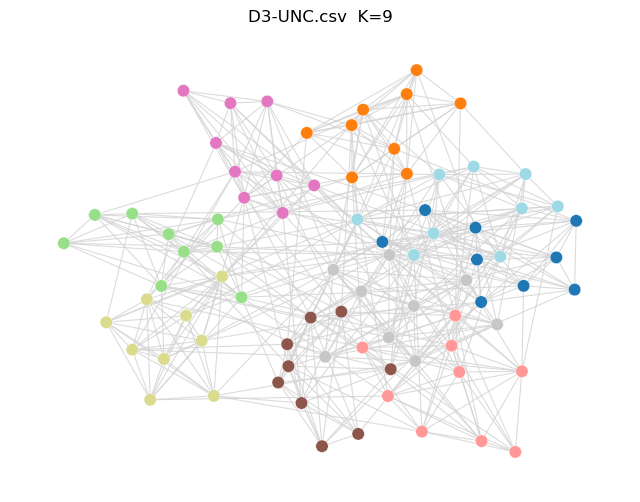

In [29]:
timings = []  # nazwa pliku, czas w sekundach

for file in sorted(os.listdir(COMP_DIR)):
    if not file.endswith(".csv"):
        continue

    in_path = os.path.join(COMP_DIR, file)
    print(f"\n=== Przetwarzam {file} ===")
    A = load_adjacency(in_path)
    n = A.shape[0]
    m = A.sum() / 2.0

    target_k = parse_target_k(file)
    if target_k is None:
        print("Brak znanego K w nazwie pliku, liczba społeczności będzie dobrana automatycznie")
    else:
        print(f"Oczekiwana liczba społeczności K = {target_k}")

    t0 = time.perf_counter()
    labels, Q, K_effective = spectral_community_detection(
        A,
        known_k=target_k,
        max_k=15,
        refine=True,
    )
    t1 = time.perf_counter()
    elapsed = t1 - t0
    timings.append((file, elapsed))

    print(f"n = {n}, m = {int(m)}, K_efektywne = {K_effective}")
    print(f"Modułowość Q = {Q:.4f}")
    print(f"Czas obliczeń: {elapsed:.4f} s")

    # zapis 
    out_path = os.path.join(OUT_DIR, file)
    write_solution_file(out_path, labels)
    print(f"Zapisano rozwiązanie do: {out_path}")


    if file in ["D1-K=2.csv", "D1-UNC.csv", "D2-K=7.csv", "D2-UNC.csv", "D3-K=12.csv", "D3-UNC.csv"]:
        plot_partition(A, labels, title=file)


In [30]:
desc_path = os.path.join(OUT_DIR, "description.txt")
with open(desc_path, "w", encoding="utf-8") as f:
    f.write(f"{STUDENT_NAME}\n")
    if GITHUB_LINK:
        f.write(f"{GITHUB_LINK}\n")
    for fname, sec in timings:
        f.write(f"{fname}, {sec:.6f}\n")

print("\nGotowe.")
print(f"Wyniki są w katalogu: {OUT_DIR}")
print(f"Plik description.txt zapisany jako: {desc_path}")


Gotowe.
Wyniki są w katalogu: ./results
Plik description.txt zapisany jako: ./results/description.txt
